# Lab13 Reinforcement Learning (RL)

Reinforcement Learning (RL) is a machine learning technique that enables an agent to learn in an interactive environment by trial and error using feedback on its actions and experiences. RL uses rewards and punishment as signals for "good" and "bad" behavior.

Generally, at each step, the agent outputs an action, which is input to the environment. The environment evolves according to its dynamics, the agent observes the new state of the environment and (optionally) a reward, and the process continues until hopefully the agent learns what behavior maximizes its reward.



### Markov decision process (MDP)

More precisely, a Markov chain is defined by a set of possible states $S={s_0, s_1, \ldots, s_n}$ and a transition matrix $T(s,s')$ containing the propbabilities of state $s$ transitioning to state $s'$

Now, the dynamics of the environment in a MDP are slightly different from that of a simple Markov chain. We have to consider how the agent's actions affect the system's dynamics. At each time step, rather than just transitioning randomly to the next state, we add the agent's action as an external input or disturbance $a \in A$, so (assuming a small number of discrete states and actions) the transition probabilities become a 3D tensor of size $|S|\times |A|\times |S|$ mapping each state/action pair to a probability distribution over the states.

### State transition function


In [1]:
import torch
### 3 states
### 2 actions
### take action1 prob to be in action in state 1 is 0.8
T = torch.tensor([[[0.8, 0.1, 0.1],
                   [0.1, 0.6, 0.3]],
                  [[0.7, 0.2, 0.1],
                   [0.1, 0.8, 0.1]],
                  [[0.6, 0.2, 0.2],
                   [0.1, 0.4, 0.5]]])

# Reward function

R = torch.tensor([1.,0.,-1.])

# Discount factor

gamma = 0.5

#### How good is a policy? Policy evaluation

to evaluate a policy (any policy) to see how good this policy is by finding value of each states calculated from this particular policy.

In [2]:
def policy_evaluation(policy, trans_matrix, rewards, gamma, threshold):
    n_state = policy.shape[0]
    V = torch.zeros(n_state)
    while True:
        V_temp = torch.zeros(n_state)
        for state, actions in enumerate(policy):
            for action, action_prob in enumerate(actions):
                V_temp[state] += action_prob * (rewards[state] + gamma * torch.dot(trans_matrix[state, action], V))
        max_delta = torch.max(torch.abs(V-V_temp))
        V = V_temp.clone()
        if max_delta <= threshold:
            break
    return V

threshold = 0.0001
policy_optimal = torch.tensor([[1.0, 0.0],
                               [1.0, 0.0],
                               [1.0, 0.0]])
V = policy_evaluation(policy_optimal, T, R, gamma, threshold)
print(V)

tensor([ 1.6786,  0.6260, -0.4821])


### Policy Iteration
Policy iteration starts with a random policy then uses policy evaluation and the resulting values to iteratively improve the policy until an optimal policy is obtained. It is, however, slow, due to the policy evaluation loop within the policy iteration loop.

Here's an implementation using a slightly different formulation fo the reward as a function  𝑅(𝑠,𝑎,𝑠′)  of the current state  𝑠 , action taken  𝑎 , and resulting state  𝑠′ :

In [3]:
def policy_evaluation(policy, trans_matrix, rewards, gamma, threshold):
    n_state = policy.shape[0]
    V = torch.zeros(n_state)
    while True:
        V_temp = torch.zeros(n_state)
        for state in range(n_state):
            action = int(policy[state].item())
            for new_state in range(n_state):
                trans_prop = trans_matrix[state, action, new_state]
                reward = rewards[state, action, new_state]
                V_temp[state] += trans_prop * (reward + gamma * V[new_state])
        max_delta = torch.max(torch.abs(V-V_temp))
        V = V_temp.clone()
        if max_delta <= threshold:
            break
    return V

def policy_improvement(trans_matrix, rewards, gamma):
    n_state = trans_matrix.shape[0]
    n_action = trans_matrix.shape[1]
    policy = torch.zeros(n_state)

    for state in range(n_state):
        v_actions = torch.zeros(n_action)
        for action in range(n_action):
            for new_state in range(n_state):
                trans_prop = trans_matrix[state, action, new_state]
                reward = rewards[state, action, new_state]
                v_actions[action] += trans_prop * (reward + gamma * V[new_state])
        policy[state] = torch.argmax(v_actions)
    return policy

def policy_iteration(trans_matrix, rewards, gamma, threshold):
    n_state = trans_matrix.shape[0]
    n_action = trans_matrix.shape[1]
    policy = torch.randint(high=n_action, size=(n_state,)).float()
    while True:
        V = policy_evaluation(policy, trans_matrix, rewards, gamma, threshold)
        policy_improved = policy_improvement(trans_matrix, rewards, gamma)
        if torch.equal(policy_improved, policy):
            return V, policy_improved
        policy = policy_improved


In [5]:
# Reward R(s,a,a') example

R2 = torch.tensor([[[0.1,0.,-0.2],
                   [0.2,0.,-0.1]],
                  [[0.3,0.,-0.5],
                   [0.1,0.,-0.2]],
                  [[0.2,0.,-0.1],
                   [1.,0.,-1.]]])


In [6]:
V_optimal, optimal_policy = policy_iteration(T, R2, gamma, threshold)
print(V_optimal)
print(optimal_policy)

tensor([0.1352, 0.2405, 0.1829])
tensor([0., 0., 0.])


### Value Iteration
Value iteration is a much more efficient way to obtain the optimial policy. It calculates the value of each state on the assumption that the agent will deterministically select the action  𝑎  in state  𝑠  that maximizes the expected reward after that. 

In [7]:
def value_iteration(trans_matrix, rewards, gamma, threshold):
    n_state = trans_matrix.shape[0]
    n_action = trans_matrix.shape[1]
    V = torch.zeros(n_state)
    while True:
        V_temp = torch.zeros(n_state)
        for state in range(n_state):
            v_actions = torch.zeros(n_action)
            for action in range(n_action):
                for new_state in range(n_state):
                    trans_prop = trans_matrix[state, action, new_state]
                    reward = rewards[state, action, new_state]
                    v_actions[action] += trans_prop * (reward + gamma * V[new_state])
            V_temp[state] = torch.max(v_actions)
        max_delta = torch.max(torch.abs(V-V_temp))
        V = V_temp.clone()
        if max_delta <= threshold:
            break
    return V

In [8]:
V = value_iteration(T, R2, gamma, threshold)
print(V)

tensor([0.1352, 0.2405, 0.1829])


### Exercise
Write some code now to find the optimal policy based on the values you got from value iteration above. Do you get the same result as for policy iteration?

In [23]:
# State transition function

T = torch.tensor([[[0.8, 0.1, 0.1],
                   [0.1, 0.6, 0.3]],
                  [[0.7, 0.2, 0.1],
                   [0.1, 0.8, 0.1]],
                  [[0.6, 0.2, 0.2],
                   [0.1, 0.4, 0.5]]])

R2 = torch.tensor([[[0.1,0.,-0.2],
                   [0.2,0.,-0.1]],
                  [[0.3,0.,-0.5],
                   [0.1,0.,-0.2]],
                  [[0.2,0.,-0.1],
                   [1.,0.,-1.]]])

gamma = 0.5
threshold = 0.0001

#%%
V = value_iteration(T, R2, gamma, threshold)

print(V)

tensor([0.1352, 0.2405, 0.1829])


In [24]:
n_state = T.shape[0]
n_action = T.shape[1]
opt_policy = [0]*n_state
for state in range(n_state):
    exp_reward = [0] * n_action
    for action in range(n_action):
        exp_reward[action] = 0
        for new_state in range(n_state):
            prob = T[state, action, new_state]
            reward = R2[state, action, new_state]
            exp_reward[action] += prob * reward * V[new_state]
    opt_policy[state] = np.argmax(exp_reward) ###### action which action

#%%
print(opt_policy)

[0, 0, 0]


### OpenAI Gym

In [25]:
import gym
# create environment
env = gym.make('SpaceInvaders-v0')

# reset environments
env.reset()

array([[[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       ...,

       [[80, 89, 22],
        [80, 89, 22],
        [80, 89, 22],
        ...,
        [80, 89, 22],
        [80, 89, 22],
        [80, 89, 22]],

       [[80, 89, 22],
        [80, 89, 22],
        [80, 89, 22],
        ...,
        [80, 89, 22],
        [80, 89, 22],
        [80, 89, 22]],

       [[80, 89, 22],
        [80, 89, 22],
        [80, 89, 22],
        ...,
        [80, 89, 22],
        [80, 89, 22],
        [80, 89, 22]]], dtype=uint8)

In [27]:
import time
env.render()
time.sleep(3)
# close the environment
env.close()

In [15]:
# import gym
# # create environment
# env = gym.make('CartPole-v0')

# # reset environments
# env.reset()

# # render the environment
# env.render()

# env.close()

In [28]:
print(env.action_space)
action = env.action_space.sample()
print(action)

Discrete(6)
3


Execute an action using `step()`.
The `step` method returns the next state after the action is taken.
 - **new_state**: The new observation
 - **reward**: The reward associated with that action in that state.
 - **is_done**: A flag to tell the game end (True).
 - **info**: extra information

In [29]:
new_state, reward, is_done, info = env.step(action)
print(is_done)
print(reward)
print(info)

False
0.0
{'ale.lives': 3}


In [30]:
is_done = False
env.reset()
while not is_done:
    action = env.action_space.sample()
    new_state, reward, is_done, info = env.step(action)
    print(info)
    env.render()

{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 

## Using the environments to do reinforcement learning

## Monte Carlo (MC) Method

Monte Carlo method is a model-free which have no require any prior knowledge of the environment. MC method is more scalable than MDP. MC control is used for finding the optimal policy when a policy is not given. There are 2 basically of MC control: on-policy and off-policy. On-policy method learns about the optimal policy by executing the policy and evaluating and improving it, while Off-policy method learns about the optimal policy using data generated by another policy.

## On-policy Monte Carlo control

On-policy Monte Carlo works look-a-like to policy iteration which has 2 phases: evaluation and improvement.
 - Evaluation phase: it evaluates the **action-values** (called **Q-function** $Q(s,a)$) instead of evaluates the value function.
 - Improvement phase: the policy is updated by assigning the optimal action to each stage: $\pi(s)=argmax_a Q(s,a)$

In this code below, we add **epsilon-greedy** policy which it will not exploit the best action all the time. The equations are:
 - Epsilon ($\epsilon$):

      $\pi(s,a)=\frac{\epsilon}{|A|}$  When $|A|$ is the number of all possible actions.
 - Greedy:
 
      $\pi(s,a)=1-\epsilon + \frac{\epsilon}{|A|}$


In [31]:
import torch
import gym
from collections import defaultdict

env = gym.make('Blackjack-v0')

In [32]:
def run_episode(env, Q, epsilon, n_action):
    state = env.reset()
    rewards = []
    actions = []
    states = []
    is_done = False
    # without epsilon-greedy
    # action = torch.randint(0, n_action, [1]).item()
    ##################################################
    while not is_done:
        # with epsilon-greedy
        probs = torch.ones(n_action) * epsilon / n_action
        best_action = torch.argmax(Q[state]).item()
        probs[best_action] += 1.0 - epsilon
        action = torch.multinomial(probs, 1).item()
        #######################################################
        actions.append(action)
        states.append(state)
        state, reward, is_done, info = env.step(action)
        rewards.append(reward)
    return states, actions, rewards

def mc_control_on_policy(env, gamma, n_episode, epsilon):
    n_action = env.action_space.n
    G_sum = defaultdict(float)
    N = defaultdict(int)
    Q = defaultdict(lambda: torch.empty(env.action_space.n))
    for episode in range(n_episode):
        states_t, actions_t, rewards_t = run_episode(env, Q, epsilon, n_action)
        return_t = 0
        G = {}
        for state_t, action_t, reward_t in zip(states_t[::-1], actions_t[::-1], rewards_t[::-1]):
            return_t = gamma * return_t + reward_t
            G[(state_t, action_t)] = return_t
            for state_action, return_t in G.items():
                state, action = state_action
                if state[0] <= 21:
                    G_sum[state_action] += return_t
                    N[state_action] += 1
                    Q[state][action] = G_sum[state_action] / N[state_action]
    policy = {}
    for state, actions in Q.items():
        policy[state] = torch.argmax(actions).item()
    return Q, policy


In [33]:
gamma = 1
n_episode = 500000
epsilon = 0.1
optimal_Q, optimal_policy = mc_control_on_policy(env, gamma, n_episode, epsilon)
# print(optimal_policy)
# print(optimal_Q)

def simulate_episode(env, policy):
    state = env.reset()
    is_done= False
    while not is_done:
        action = policy[state]
        state, reward, is_done, info = env.step(action)
        if is_done:
            return reward

n_episode = 100
n_win_optimal = 0
n_lose_optimal = 0
for _ in range(n_episode):
    reward = simulate_episode(env, optimal_policy)
    if reward == 1:
        n_win_optimal += 1
    elif reward == -1:
        n_lose_optimal += 1
print('after episode 100, win ', n_win_optimal, ' lose ', n_lose_optimal)

after episode 100, win  51  lose  43


## Off-policy Monte Carlo control

The Off-policy method optimizes the **target policy** ($\pi$) using data generated by another policy (**behavior policy** ($b$)).
 - Target policy: exploitation purposes, greedy with respect to its current Q-function.
 - Behavior policy: exploration purposes, generate behavior which the target policy used for learning. The behavior policy can be anything to confirm that it can explore all possibilities, then all actions and all states can be chosen with non-zero probabilities.

The weight importand for state-action pair is calculated as:

$w_t=\sum_{k=t}[\pi(a_k|s_k)/b(a_k|s_k)]$
 - $\pi(a_k|s_k)$: probabilities of taking action $a_k$ in state $s_k$
 - $b(a_k|s_k)$: probabilities under the behavior policy.

In [ ]:
import torch
import gym
from collections import defaultdict

env = gym.make('Blackjack-v0')

In [ ]:
def gen_random_policy(n_action):
    probs = torch.ones(n_action) / n_action
    def policy_function(state):
        return probs
    return policy_function

In [ ]:
random_policy = gen_random_policy(env.action_space.n)

In [ ]:
def run_episode(env, behavior_policy):
    state = env.reset()
    rewards = []
    actions = []
    states = []
    is_done = False
    while not is_done:
        probs = behavior_policy(state)
        action = torch.multinomial(probs, 1).item()
        actions.append(action)
        states.append(state)
        state, reward, is_done, info = env.step(action)
        rewards.append(reward)
        if is_done:
            break
    return states, actions, rewards

def mc_control_off_policy(env, gamma, n_episode, behavior_policy):
    n_action = env.action_space.n
    G_sum = defaultdict(float)
    N = defaultdict(int)
    Q = defaultdict(lambda: torch.empty(n_action))
    for episode in range(n_episode):
        W = {}
        w = 1
        states_t, actions_t, rewards_t = run_episode(env, behavior_policy)
        return_t = 0
        G = {}
        for state_t, action_t, reward_t in zip(states_t[::-1], actions_t[::-1], rewards_t[::-1]):
            return_t = gamma * return_t + reward_t
            G[(state_t, action_t)] = return_t
            w *= 1./ behavior_policy(state_t)[action_t]
            W[(state_t, action_t)] = w
            if action_t != torch.argmax(Q[state_t]).item():
                break
            
        for state_action, return_t in G.items():
            state, action = state_action
            if state[0] <= 21:
                G_sum[state_action] += return_t * W[state_action]
                N[state_action] += 1
                Q[state][action] = G_sum[state_action] / N[state_action]
    policy = {}
    for state, actions in Q.items():
        policy[state] = torch.argmax(actions).item()
    return Q, policy


In [ ]:
gamma = 1
n_episode = 500000
optimal_Q, optimal_policy = mc_control_off_policy(env, gamma, n_episode, random_policy)
print(optimal_policy)
print(optimal_Q)

In [ ]:
def simulate_episode(env, policy):
    state = env.reset()
    is_done= False
    while not is_done:
        action = policy[state]
        state, reward, is_done, info = env.step(action)
        if is_done:
            return reward

In [ ]:
def simulate_episode(env, policy):
    state = env.reset()
    is_done= False
    while not is_done:
        action = policy[state]
        state, reward, is_done, info = env.step(action)
        if is_done:
            return reward

## Important method

As the example environments in Gym, the important methods that we need to make it in our own simulator are:
 - *reset*
 - *step*
 - *render*
 - *action_space.n* or *n_action*
 - *legal_action*

Other methods are our define.

Thus, we can understand environments of gym. Now let's try to create your own environment in Tic-tac-toe game by do look-a-like gym class.

In [1]:
import os
import numpy

from games.abstract_game import AbstractGame
import importlib


game_name = 'tictactoe'
game_module = importlib.import_module("games." + game_name)
env = game_module.Game()

env.reset()

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]]], dtype=int32)

In [2]:
env.reset()

next_state, reward, done = env.step(4)
print(next_state, 'reward', reward, 'is_done:', done)

next_state, reward, done = env.step(5)
print(next_state, 'reward', reward, 'is_done:', done)

next_state, reward, done = env.step(1)
print(next_state, 'reward', reward, 'is_done:', done)

next_state, reward, done = env.step(6)
print(next_state, 'reward', reward, 'is_done:', done)

next_state, reward, done = env.step(7)
print(next_state, 'reward', reward, 'is_done:', done)

[[[ 0  0  0]
  [ 0  1  0]
  [ 0  0  0]]

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]

 [[-1 -1 -1]
  [-1 -1 -1]
  [-1 -1 -1]]] reward 0 is_done: False
[[[0 0 0]
  [0 1 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 1]
  [0 0 0]]

 [[1 1 1]
  [1 1 1]
  [1 1 1]]] reward 0 is_done: False
[[[ 0  1  0]
  [ 0  1  0]
  [ 0  0  0]]

 [[ 0  0  0]
  [ 0  0  1]
  [ 0  0  0]]

 [[-1 -1 -1]
  [-1 -1 -1]
  [-1 -1 -1]]] reward 0 is_done: False
[[[0 1 0]
  [0 1 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 1]
  [1 0 0]]

 [[1 1 1]
  [1 1 1]
  [1 1 1]]] reward 0 is_done: False
[[[ 0  1  0]
  [ 0  1  0]
  [ 0  1  0]]

 [[ 0  0  0]
  [ 0  0  1]
  [ 1  0  0]]

 [[-1 -1 -1]
  [-1 -1 -1]
  [-1 -1 -1]]] reward 1 is_done: True


In [3]:
env.render()

   | O |   
---+---+---
   | O | X 
---+---+---
 X | O |   


## Temporal Difference (TD)
Temporal Difference (TD) learning is a model-free learning algorithm like MC learning. In MC learning, Q-function is called and updated at the end of the entire episode, but TD learning update Q-function every step of an episode. One of the TD learning algorithm is Q-learning

## Q-Learning

Q-leaning is an off-policy learning algorithm. The Q-function is based on the equation:

$Q(s,a)=Q(s,a)+\alpha(r+\gamma\max_{a'}Q(s',a')-Q(s,a))$

Where
 - $\alpha$: learning rate
 - $\gamma$: discount factor
 - $\max_{a'}Q(s',a')$: greedy behavior policy, the highest Q-value among those in state $s'$ is selected to generate learning data.

We know from class that Q-learning finds the optimal greedy policy while running an epsilon-greedy policy. 

In [4]:
import importlib
from collections import defaultdict
import torch
import numpy

game_name = 'tictactoe'
game_module = importlib.import_module("games." + game_name)
env = game_module.Game()

env.reset()

# defining epsilon-greedy policy
def gen_epsilon_greedy_policy(n_action, epsilon):
    def policy_function(state, Q, available_actions):
        probs = torch.ones(n_action) * epsilon / n_action
        # print(probs)
        # print(state)
        # print(Q[state])
        best_action = torch.argmax(Q[state]).item()
        if not(best_action in available_actions):
            best_action = -1
            Q_max = -800000000
            for i in range(n_action):
                if i in available_actions and Q_max < Q[state][i]:
                    Q_max = Q[state][i]
                    best_action = i
        probs[best_action] += 1.0 - epsilon
        action = torch.multinomial(probs, 1).item()
        return action
    return policy_function

def q_learning(env, gamma, n_episode, alpha, player):
    """
    Obtain the optimal policy with off-policy Q-learning method
    @param env: OpenAI Gym environment
    @param gamma: discount factor
    @param n_episode: number of episodes
    @return: the optimal Q-function, and the optimal policy
    """
    n_action = 9
    Q = defaultdict(lambda: torch.zeros(n_action))
    for episode in range(n_episode):
        if episode % 10000 == 9999:
            print("episode: ", episode + 1)
        state = env.reset()
        state = hash(tuple(state.reshape(-1)))

        is_done = False
        while not is_done:
            if env.to_play() == player:
                available_action = env.legal_actions()
                action = epsilon_greedy_policy(state, Q, available_action)
                next_state, reward, is_done = env.step(action)
                next_state = hash(tuple(next_state.reshape(-1)))
                td_delta = reward + gamma * torch.max(Q[next_state]) - Q[state][action]
                Q[state][action] += alpha * td_delta
            else:
                action = env.expert_agent()
                next_state, reward, is_done = env.step(action)
                next_state = hash(tuple(next_state.reshape(-1)))

                if is_done:
                    reward = -reward
                    td_delta = reward + gamma * torch.max(Q[next_state]) - Q[state][action]
                    Q[state][action] += alpha * td_delta

            length_episode[episode] += 1
            total_reward_episode[episode] += reward

            if is_done:
                break
            state = next_state

    policy = {}
    for state, actions in Q.items():
        policy[state] = torch.argmax(actions).item()
    return Q, policy

gamma = 1

n_episode = 1000000

alpha = 0.4

epsilon = 0.1

available_action = env.legal_actions()
epsilon_greedy_policy = gen_epsilon_greedy_policy(9, epsilon)

length_episode = [0] * n_episode
total_reward_episode = [0] * n_episode

# agent play first
optimal_Q, optimal_policy = q_learning(env, gamma, n_episode, alpha, 1)


print('The optimal policy:\n', optimal_policy)

episode:  10000
episode:  20000
episode:  30000
episode:  40000
episode:  50000
episode:  60000
episode:  70000
episode:  80000
episode:  90000
episode:  100000
episode:  110000
episode:  120000
episode:  130000
episode:  140000
episode:  150000
episode:  160000
episode:  170000
episode:  180000
episode:  190000
episode:  200000
episode:  210000
episode:  220000
episode:  230000
episode:  240000
episode:  250000
episode:  260000
episode:  270000
episode:  280000
episode:  290000
episode:  300000
episode:  310000
episode:  320000
episode:  330000
episode:  340000
episode:  350000
episode:  360000
episode:  370000
episode:  380000
episode:  390000
episode:  400000
episode:  410000
episode:  420000
episode:  430000
episode:  440000
episode:  450000
episode:  460000
episode:  470000
episode:  480000
episode:  490000
episode:  500000
episode:  510000
episode:  520000
episode:  530000
episode:  540000
episode:  550000
episode:  560000
episode:  570000
episode:  580000
episode:  590000
episod

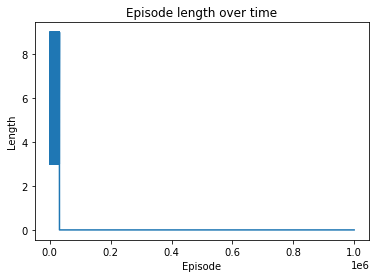

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


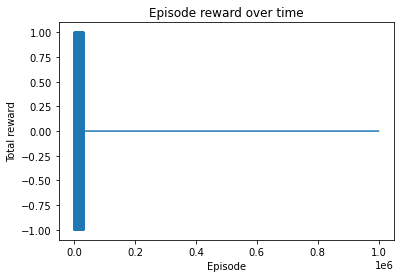

In [6]:
import matplotlib.pyplot as plt

plt.plot(length_episode)
plt.title('Episode length over time')
plt.xlabel('Episode')
plt.ylabel('Length')
plt.show()


plt.plot(total_reward_episode)
print(total_reward_episode[-100:])
plt.title('Episode reward over time')
plt.xlabel('Episode')
plt.ylabel('Total reward')
plt.show()

In [7]:
state = env.reset()
state = hash(tuple(state.reshape(-1)))

player = 1
is_done = False
while not is_done:
    if env.to_play() == player:
        available_action = env.legal_actions()
        print("available action:",available_action)
        action = epsilon_greedy_policy(state, optimal_Q, available_action)
        next_state, reward, is_done = env.step(action)
        next_state = hash(tuple(next_state.reshape(-1)))
        print("RL agent")
        print(env.action_to_string(action))
    else:
        action = env.expert_agent()
        next_state, reward, is_done = env.step(action)
        next_state = hash(tuple(next_state.reshape(-1)))
        print("Expert agent")
        print(env.action_to_string(action))

    state = next_state
    env.render()

available action: [0, 1, 2, 3, 4, 5, 6, 7, 8]
RL agent
Play row 1, column 1
 O |   |   
---+---+---
   |   |   
---+---+---
   |   |   
Expert agent
Play row 2, column 3
 O |   |   
---+---+---
   |   | X 
---+---+---
   |   |   
available action: [1, 2, 3, 4, 6, 7, 8]
RL agent
Play row 1, column 2
 O | O |   
---+---+---
   |   | X 
---+---+---
   |   |   
Expert agent
Play row 1, column 3
 O | O | X 
---+---+---
   |   | X 
---+---+---
   |   |   
available action: [3, 4, 6, 7, 8]
RL agent
Play row 2, column 1
 O | O | X 
---+---+---
 O |   | X 
---+---+---
   |   |   
Expert agent
Play row 3, column 3
 O | O | X 
---+---+---
 O |   | X 
---+---+---
   |   | X 


state = env.reset()
## SARSA

In contrast, Q-learning is an off-policy TD learning algorithm, SARSA is an **on-policy TD learning** algorithm.

SARSA (full name: State-Action-Reward-State-Action) looked similar to Q-learning which forcuses on state-action value. The Q-function is:

$Q(s,a)=Q(s,a)+\alpha(r+\gamma Q(s',a')-Q(s,a))$

In stead of using behavior-greedy policy $\max_{a'}Q(s',a')$ like Q-learning, SARSA just select the next action $a'$ following an epsilon-greedy policy to update the Q-value.
However, the action $a'$ must use in the next step (no matter what).

It may not good for 2 players games (What happen if our opponent not play in the same position?)

## SARSA code example

    def gen_epsilon_greedy_policy(n_action, epsilon):
        def policy_function(state, Q):
            probs = torch.ones(n_action) * epsilon / n_action
            best_action = torch.argmax(Q[state]).item()
            probs[best_action] += 1.0 - epsilon
            action = torch.multinomial(probs, 1).item()
            return action
        return policy_function

    def sarsa(env, gamma, n_episode, alpha):
        """
        Obtain the optimal policy with on-policy SARSA algorithm
        @param env: OpenAI Gym environment
        @param gamma: discount factor
        @param n_episode: number of episodes
        @return: the optimal Q-function, and the optimal policy
        """
        n_action = env.action_space.n
        Q = defaultdict(lambda: torch.zeros(n_action))
        for episode in range(n_episode):
            state = env.reset()
            is_done = False
            action = epsilon_greedy_policy(state, Q)
            while not is_done:
                next_state, reward, is_done, info = env.step(action)
                next_action = epsilon_greedy_policy(next_state, Q)
                td_delta = reward + gamma * Q[next_state][next_action] - Q[state][action]
                Q[state][action] += alpha * td_delta
                length_episode[episode] += 1
                total_reward_episode[episode] += reward
                if is_done:
                    break
                state = next_state
                action = next_action
        policy = {}
        for state, actions in Q.items():
            policy[state] = torch.argmax(actions).item()
        return Q, policy

## Experience replay

To improve the performance of Q-learning, we use **experience replay**.

**Experience replay** means we store the agent's experiences during an episode instead of running Q-learning. The learning phase with experience replay becomes two phases: gaining experience and updating models based on the experience obtained after an episode finishes. Specifically, the experience (also called the buffer, or memory) includes the past state, the action taken, the reward received, and the next state for individual steps in an episode.

In the learning phase, a certain number of data points are randomly sampled from the experience and are used to train the learning models. Experience replay can stabilize training by providing a set of samples with low correlation, which, as a result, increases learning efficiency.

#### In Lab

In [25]:
import math, random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F

import matplotlib.pyplot as plt

import gym
import numpy as np

from collections import deque
from tqdm import trange

import importlib
from collections import defaultdict
import torch
import numpy

# Select GPU or CPU as device

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [26]:

# Epsilon annealing schedule generator

def gen_eps_by_episode(epsilon_start, epsilon_final, epsilon_decay):
    eps_by_episode = lambda episode: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * episode / epsilon_decay)
    return eps_by_episode

epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500
eps_by_episode = gen_eps_by_episode(epsilon_start, epsilon_final, epsilon_decay)

In [27]:
class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        # Add batch index dimension to state representations
        state = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)            
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)

In [28]:
class DQN(nn.Module):
    
    def __init__(self, n_state, n_action):
        super(DQN, self).__init__()        
        self.layers = nn.Sequential(
            nn.Linear(n_state, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Linear(10, n_action)
        )
        
    def forward(self, x):
        
        return self.layers(x)
    
    def act(self, state, epsilon):
        # Get an epsilon greedy action for given state
        if random.random() > epsilon: # Use argmax_a Q(s,a)
            state = autograd.Variable(torch.FloatTensor(state).unsqueeze(0), volatile=True).to(device)
            q_value = self.forward(state)
            q_value = q_value.cpu()
            action = q_value.max(1)[1].item()            
        else: # get random action
            action = random.randrange(n_action)
        return action

In [29]:
def plot(episode, rewards, losses):
    # clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('episode %s. reward: %s' % (episode, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)   
    plt.show()

In [30]:
def train(env, model, eps_by_episode, optimizer, replay_buffer, episodes = 10000, batch_size=32, gamma = 0.99):
    losses = []
    all_rewards = []
    episode_reward = 0
    tot_reward = 0
    tr = trange(episodes+1, desc='Agent training', leave=True)

    # Get initial state input
    state = env.reset()
    state = state.reshape(27)
    
    # Execute episodes iterations
    for episode in tr:
        tr.set_description("Agent training (episode{}) Avg Reward {}".format(episode+1,tot_reward/(episode+1)))
        tr.refresh() 

        # Get initial epsilon greedy action
        epsilon = eps_by_episode(episode)
        state = state.reshape(27)
        action = model.act(state, epsilon)
        
        # Take a step
        next_state, reward, done = env.step(action)
        next_state = next_state.reshape(27)
        
        # Append experience to replay buffer
        replay_buffer.push(state, action, reward, next_state, done)

        tot_reward += reward
        episode_reward += reward
        
        state = next_state

        # Start a new episode if done signal is received
        if done:
            state = env.reset()
            all_rewards.append(episode_reward)
            episode_reward = 0

        # Train on a batch if we've got enough experience
        if len(replay_buffer) > batch_size:
            loss = compute_td_loss(model, batch_size, gamma)
            losses.append(loss.item())
            
    plot(episode, all_rewards, losses)  
    return model,all_rewards, losses


In [34]:
def compute_td_loss(model, batch_size, gamma=0.99):

    # Get batch from replay buffer
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    # Convert to tensors. Creating Variables is not necessary with more recent PyTorch versions.
    state      = autograd.Variable(torch.FloatTensor(np.float32(state))).to(device)
    next_state = autograd.Variable(torch.FloatTensor(np.float32(next_state)), volatile=True).to(device)
    action     = autograd.Variable(torch.LongTensor(action)).to(device)
    reward     = autograd.Variable(torch.FloatTensor(reward)).to(device)
    done       = autograd.Variable(torch.FloatTensor(done)).to(device)

    
    # Calculate Q(s) and Q(s')
    q_values      = model(state)
    next_q_values = model(next_state)

    # Get Q(s,a) and max_a' Q(s',a')
    q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    next_q_value     = next_q_values.max(1)[0]
    # Calculate target for Q(s,a): r + gamma max_a' Q(s',a')
    # Note that the done signal is used to terminate recursion at end of episode.
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    
    # Calculate MSE loss. Variables are not needed in recent PyTorch versions.
    loss = (q_value - autograd.Variable(expected_q_value.data)).pow(2).mean()
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss

In [35]:
game_name = 'tictactoe'
game_module = importlib.import_module("games." + game_name)
env = game_module.Game()

env.reset()

n_state = 27

n_action = 9

model = DQN(n_state = n_state, n_action = n_action).to(device)
    
optimizer = optim.Adam(model.parameters())

replay_buffer = ReplayBuffer(1000)

Agent training (episode33) Avg Reward -0.12121212121212122:   3%|▎         | 31/1001 [00:00<00:05, 173.73it/s]<ipython-input-28-04b399177c43>:20: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  state = autograd.Variable(torch.FloatTensor(state).unsqueeze(0), volatile=True).to(device)
<ipython-input-34-4d13cf9fab04>:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  next_state = autograd.Variable(torch.FloatTensor(np.float32(next_state)), volatile=True).to(device)
Agent training (episode1001) Avg Reward -0.16783216783216784: 100%|██████████| 1001/1001 [00:13<00:00, 76.61it/s]


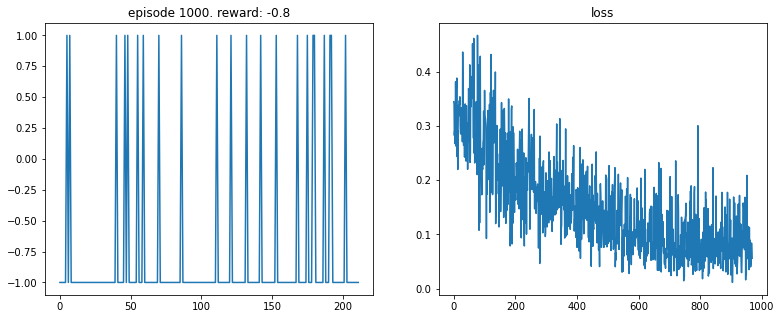

In [36]:
model,all_rewards, losses = train(env, model, eps_by_episode, optimizer, replay_buffer, episodes = 1000, batch_size=32, gamma = 0.99)

In [12]:
losses

[]

In [ ]:
import time
def play_game(model):
    state = env.reset()
    state = state.reshape(27)
    action = model.act(state, epsilon_final)
    next_state, reward, done = env.step(action)
    next_state = next_state.reshape(27)
    time.sleep(0.03)
    state = next_state

play_game(model)
# time.sleep(3)
# env.close()

In [ ]:
state = env.reset()
state = hash(tuple(state.reshape(-1)))

player = 1
is_done = False
while not is_done:
    if env.to_play() == player:
        available_action = env.legal_actions()
        print("available action:",available_action)
        action = epsilon_greedy_policy(state, optimal_Q, available_action)
        next_state, reward, is_done = env.step(action)
        next_state = hash(tuple(next_state.reshape(-1)))
        print("RL agent")
        print(env.action_to_string(action))
    else:
        action = env.expert_agent()
        next_state, reward, is_done = env.step(action)
        next_state = hash(tuple(next_state.reshape(-1)))
        print("Expert agent")
        print(env.action_to_string(action))

    state = next_state
    env.render()